In [25]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as sco

## 📊 Downloading Stock Data

Here I’m downloading stock price data for a few well-known companies using the **yfinance** library.

- I created a list of stock symbols (Apple, Amazon, Meta, Berkshire Hathaway, and Visa).
- Then I set the date range from **January 2021** to **October 2025** to get recent data.
- The `yf.download()` function grabs all the stock data (open, high, low, close, volume, etc.) directly from Yahoo Finance.
- From that, I only picked the **closing prices** using `data.loc[:, "Close"]` because that’s what I’ll use to calculate returns.
- Finally, `names_stock = data_close.columns.tolist()` saves all the stock names (the columns) in a list, so I can easily use them later for plotting and analysis.

In short → I’m telling Python to pull stock prices for 5 companies over the last few years and get them ready for portfolio analysis.


In [26]:
#download data
symbol_list= ["AAPL", "AMZN","META","BRK-B","V"]
start_period = "2021-01-01"
end_period = "2025-10-01"
data = yf.download(symbol_list, start= start_period, end = end_period)
data_close= data.loc[:, "Close"]
names_stocks = data_close.columns.tolist()



/var/folders/4p/mcmyb0f108x09z8thm8wqk900000gn/T/ipykernel_37918/1149439654.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol_list, start= start_period, end = end_period)
[*********************100%***********************]  5 of 5 completed


## 📈 Plotting Historical Stock Prices

Before doing any calculations, I want to see how the stock prices have moved over time.  
This helps me understand their trends, ups and downs, and if any stocks look more volatile than others.

Here I’m using the `pandas` built-in `.plot()` function (which uses matplotlib under the hood) to draw the chart.

- **`data_close.plot()`** → draws the price lines for all the stocks.  
- **`plt.title("Stock Prices 2021-2025")`** → adds a title to the graph.  
- **`plt.legend()`** → shows the stock names on the side so I know which line is which.  
- **`plt.show()`** → displays the plot.

In short → I’m visualizing how each company’s stock price changed over time between 2021 and 2025.


<function matplotlib.pyplot.show(close=None, block=None)>

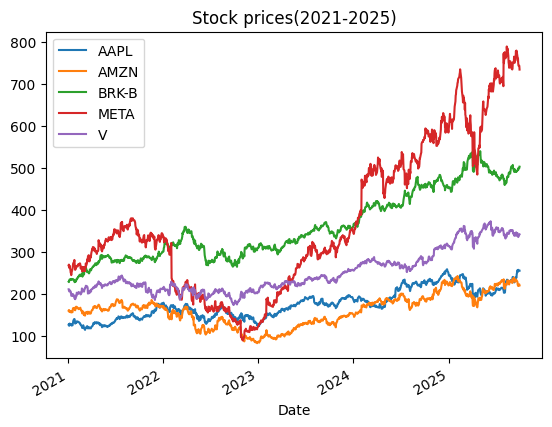

In [27]:
data_close.plot()
plt.title("Stock prices(2021-2025)")
plt.legend()
plt.show

## 📈 Normalizing Stock Prices

In the previous chart, it was hard to compare the stocks because each company starts at a different price level.

To fix that, I’m **normalizing** the prices — this means:
- I divide each stock’s price by its value on the first day,  
- then multiply by 100, so every stock starts at **100**.

This doesn’t change the shape of the price curve — it just puts all the stocks on the *same scale*.

Now I can easily compare which stock performed better or worse over time.

In short → this chart shows how much each stock has grown (or fallen) in percentage terms since the start.


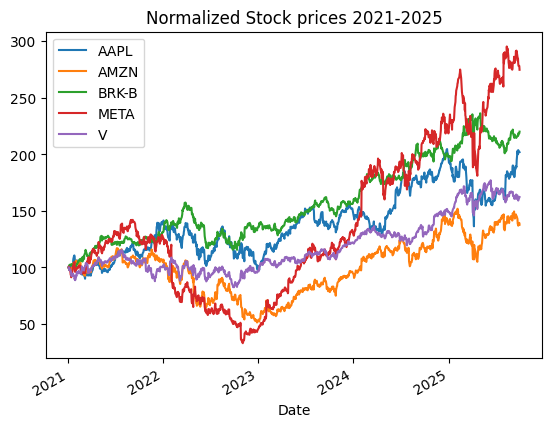

In [28]:
nhprice= data_close/ data_close.iloc[0,:]*100 #Take the first row (0) and all columns (:).” So this grabs the very first price of each stock (the starting point):
nhprice.plot()
plt.title("Normalized Stock prices 2021-2025")
plt.legend()
plt.show()

## 📊 Estimating Mean Return and Covariance

Now that I have the stock prices, I want to measure how much each stock moves and how they move together.

- **Return:** tells how much a stock’s price changes (up or down) each day.  
- **Covariance:** tells how two stocks move in relation to each other — do they go up and down together, or move in opposite directions?

### Step-by-step:
1. **`np.log(data_close).diff()`**  
   - Takes the natural log of prices and finds the difference between days.  
   - This gives us *log returns* (which are smoother and more accurate for finance).

2. **`.dropna()`**  
   - Removes the first row because it has no previous day to compare to.

3. **`data_ret * 252`**  
   - Multiplies daily returns by **252** because there are roughly 252 trading days in a year.  
   - This converts **daily returns → annual returns**.

4. **`.mean()` and `.cov()`**  
   - `mean()` gives the *average return* (expected yearly return for each stock).  
   - `cov()` gives the *covariance matrix*, showing how the stocks move together.

### In short:
We’re basically telling Python:
> “Calculate how much each stock moves each day, how they move together,  
> and then scale it up to understand their yearly behavior.”


In [29]:
#  Estimate Return and Covariance 

# Calculate daily log returns
data_ret = np.log(data_close).diff().dropna() # calculates daily % change (log returns); removes first row since no previous day


# Convert daily returns to annual returns
data_return = data_ret * 252

# Mean (expected) annual returns
mean_returns = data_return.mean().values

# Covariance matrix of annual returns
data_covariance = data_ret.cov() * 252


## 🎲 Generating 10,000 Random Portfolios

Now I’m testing 10,000 random ways to invest across all my stocks to see how each one performs.

Each portfolio has random weights (how much money goes into each stock),  
but the total always adds up to 100%.

For every random portfolio:
- I calculate the **expected return** using the formula → Rₚ = wᵀμ  
  (how much I can earn on average)
- Then the **variance and risk (volatility)** using → σₚ² = wᵀΣw  
  (how much it moves up or down)

Finally, I store all results in two lists:
- `returns_list` → for returns  
- `volatility_list` → for risk  

In simple words →  
I’m generating 10,000 random portfolios to see how risk and return change depending on how I split my money.


In [40]:
return_list =[]
volatility_list = []
for i in range(10000):
    rweights= np.random.random(len(names_stocks))  #use NumPy's random() function inside its random module
    normalized_weights= rweights/np.sum(rweights)
    #random profilio: expected return
    rpreturn= mean_returns.dot(normalized_weights) # portfolio return = wᵀμ
    return_list.append(rpreturn) # save return # append results to return list
    # random portfolio variance 
    rpvariance = np.dot(np.dot(normalized_weights.T, data_covariance),normalized_weights) # σp² = wᵀΣw → portfolio variance (overall risk based on asset weights and covariance) 
    #Step 1: Multiply weights by covariance (inner np.dot)
#Step 2: Multiply that result by weights again (outer np.dot)
# final result = total portfolio variance
    rpstd = np.sqrt(rpvariance)# random portfolio standard deviation
    volatility_list.append(rpstd)






## 🎨 Visualizing 10,000 Random Portfolios

Now that we’ve calculated the return and risk (volatility) for each random portfolio,  
let’s visualize them to understand the relationship between **risk and reward**.

Each dot in this scatter plot represents **one portfolio**:
- The **x-axis** shows how risky it is (volatility).  
- The **y-axis** shows how much return it can give on average.  

By plotting 10,000 portfolios, we can clearly see the **risk–return trade-off** —  
some portfolios have low risk and low return, while others have high risk and potentially higher return.

The “upper edge” of this cloud of points represents the **efficient frontier**,  
where portfolios give the **best return for their level of risk**.


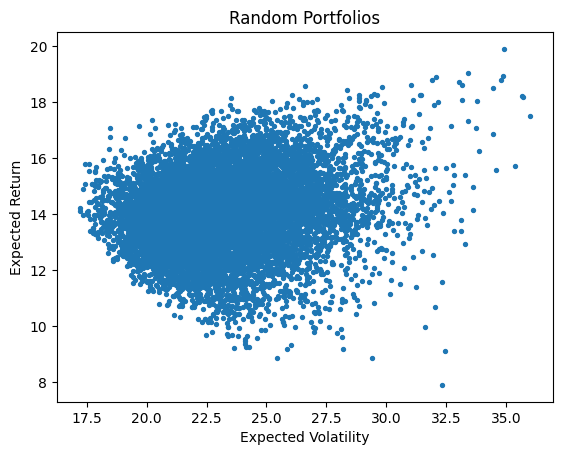

In [41]:
## Portfolio Random Weights: DataFrame with Returns and Volatility
ptrw = pd.DataFrame({'Return': return_list, 'Volatility': volatility_list}) * 100  # make percentage values

ptrw.plot(x='Volatility', y='Return', kind='scatter', s=8)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Random Portfolios')
plt.show()


### 📈 Portfolio Optimization (Mean-Variance)

We’re now finding the **best portfolio** — the one that gives the *lowest risk* for a certain target return (like 25%).

Before, we made 10,000 random portfolios just to *see* how returns and risk behave.  
Now, we’ll use **math to find the exact best mix** of stocks instead of guessing.

### 🧮 What’s Happening

- We create two functions:
  - `mean_portfolio()` → calculates portfolio’s **average return** (wᵀμ)
  - `std_portfolio()` → calculates portfolio’s **risk/volatility** (√(wᵀΣw))

- The variable **`args`** will store two things:
  - average returns (μ)
  - covariance matrix (Σ)
  These are passed inside the solver (`sco.minimize`) later.

- Then we’ll set:
  - **`bounds`** → makes sure each stock weight stays between 0 and 1  
  - **`initial_weights`** → starting guess  
  - **`constraints`** → total weights = 1 and target return = 25%

---

🧠 In short:
We’re teaching Python how to calculate **return** and **risk**,  
so it can automatically find the most efficient portfolio — the *perfect balance between safety and profit*.


In [54]:
# Mean variance portfolio optimization

#calculate returns
def mean_portfolio(weights,mean_returns):
    mean_returns=args[0]
    portfolio_return= mean_returns.dot(weights)
    return portfolio_return

# calculate volatility
def std_portfolio(weights,mean_returns, cov_matrix):
    covariance_returns=args[1]
    portfolio_volatility=np.sqrt(np.dot(weights.T,np.dot(covariance_returns,weights)))
    return portfolio_volatility
    

lower_bound and upper_bound set how much you can invest in each stock.
Here, each weight must be between 0 and 1 (no short selling, no over-investing).
bounds creates those limits for every stock.
initial_weights starts by splitting your money equally across all stocks.
args stores the average returns and covariance matrix of your data, which describe how stocks move.
target_return_p sets your goal return (25% = 0.25).
constraints tell the optimizer two rules:
Portfolio’s expected return must equal target_return_p.
All weights must add up to 1 (you invest 100% of your money).

In [43]:
lower_bound =0
upper_bound=1
bounds= tuple((lower_bound, upper_bound) for i in range(len(names_stocks)))
#intitial weights
initial_weights = np.ones(len(names_stocks))/len(names_stocks)

#args (mean vector, covariance vector)
args= (data_return.mean(),data_return.cov())
target_return_p =0.25
constraints= ({'type':'eq','fun':lambda x : mean_portfolio(x)-target_return_p},{'type':'eq','fun': lambda x :np.sum(x)-1})

sco.minimize() tells the computer to find the lowest-risk portfolio that meets your constraints.
std_portfolio = function that calculates the risk (standard deviation).
method='SLSQP' = a solver good for problems with rules and limits.
bounds and constraints keep the solution valid.
result_p stores all results from the optimizer.
result_p.x gives the best combination of stock weights.
print(weights_p) shows those final weights — your optimal portfolio allocation.

In [51]:
#optimization results
result_p= sco.minimize(std_portfolio, initial_weights,args=args,method='SLSQP',bounds=bounds,constraints=constraints)
weights_p=result_p.x
print(weights_p)

[0.00000000e+00 4.94215779e-13 0.00000000e+00 1.00000000e+00
 0.00000000e+00]


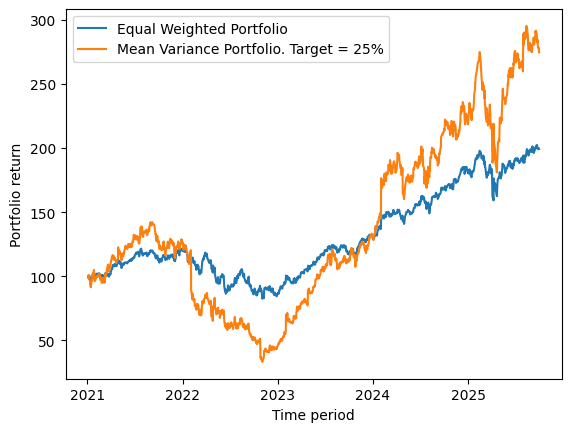

In [52]:
optimal_portfolio = nhprice.dot(weights_p)

equal_weighted = np.ones(len(names_stocks)) / len(names_stocks)
equal_weighted_portfolio = nhprice.dot(equal_weighted)

plt.plot(equal_weighted_portfolio, label="Equal Weighted Portfolio")
plt.plot(optimal_portfolio, label=f"Mean Variance Portfolio. Target = {target_return_p * 100:.0f}%")
plt.xlabel('Time period')
plt.ylabel('Portfolio return')
plt.legend()
plt.show()


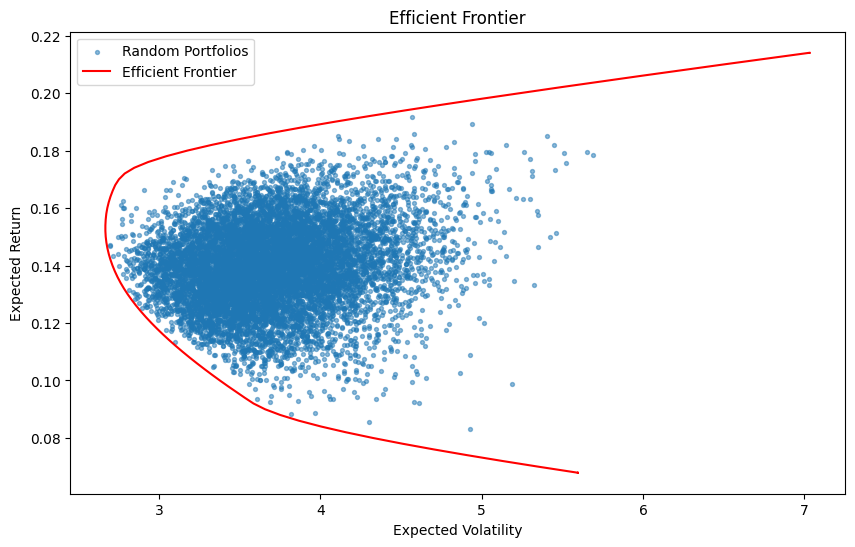

In [64]:
#### Get Efficient Frontier ####
# Generate random portfolios for the scatter plot
num_portfolios = 10000
returns_random = []
volatility_random = []

for i in range(num_portfolios):
    weights = np.random.random(len(names_stocks))
    weights /= np.sum(weights)
    port_return = np.dot(weights, args[0])
    port_vol = np.sqrt(np.dot(weights.T, np.dot(args[1], weights)))
    returns_random.append(port_return)
    volatility_random.append(port_vol)


# List to get Efficient Frontier returns and volatilities
returns_frontier = []
volatility_frontier = []

# Make a loop to get the Efficient Frontier return and Volatility
for ii in range(1, 150):
    target_return = ii / 500  # smaller step for smoother curve

    # Constraints
    constraints = (
        {'type': 'eq', 'fun': lambda x: mean_portfolio(x, args[0]) - target_return},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    )

    # Optimization results
    result = sco.minimize(std_portfolio, initial_weights, args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)

    # Optimal weights
    optimal_weights = result.x

    # Efficient Frontier Portfolio: Expected Return
    epfreturn = np.dot(optimal_weights, args[0])
    returns_frontier.append(epfreturn)

    # Efficient Frontier Portfolio: Standard Deviation
    epfvariance = np.dot(np.dot(optimal_weights.T, args[1]), optimal_weights)
    epfstd = np.sqrt(epfvariance)
    volatility_frontier.append(epfstd)

# Pandas Efficient Frontier: return and volatility
ef_portfolio = pd.DataFrame({'Return': returns_frontier, 'Volatility': volatility_frontier})

# Plot Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(volatility_random, returns_random, s=8, alpha=0.5, label="Random Portfolios")
plt.plot(ef_portfolio.Volatility, ef_portfolio.Return, color="red", label="Efficient Frontier")
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title("Efficient Frontier")
plt.legend()
plt.show()
